# 仮想合成人口個票の簡易な実装を用いた感染症シミュレーション

## 大目的

↓を使った感染症シミュレーションを作る。

《JRF-2018/simple_synthetic_population: 仮想合成人口個票の簡易な実装》  
https://github.com/JRF-2018/simple_synthetic_population

## どういうシミュレーションにしたいか？

  * simple_syntetic_population の Person や Family を拡張し、職業や所属する組織などをよい感じに設定する。時間経過でどの組織に参加しているかが変わる中で、ある感染症がどのように広がるかをシミュレーションする。

  * 個人には、いくつかモードがあり、少なくともオンモードとオフモードがある。自己隔離中はオフモードになる。オンモードには生活史があり、それは組織移動にある。組織は組織人数(実構成員)と組織内感染度と全体感染度のパラメータを持つ。

  * 例えば、学校はクラスが最大30人とし、高い組織内感染度を持つ。また、全校に対する全体感染度を持つ。全校といっても全人口と接触するわけではないが、それは単純化して全人口と接触するとモデル化する。

  * 1時間単位でシミュレーションする。大人の一例は満員電車に乗って通勤し、組織(会社)に属し、夜の街(組織内感染度低いが全体感染度高い)に行って家に帰る…とする。

  * 大人男性と一部女性の組織の人数はポワソン分布でいいかな？ リタイアした人と主婦は感染しにくい感じで。この辺、イイ感じにパラメータを設定する。

  * シミュレーション実行後、次の段階として CmdStanPy で SIR モデルとマッチングし、R0 や R(t) を計算する。


## 著者

JRF ( http://jrf.cocolog-nifty.com/statuses , Twitter (X): @jion_rockford )

## ライセンス

基本的に私が作ったのは仕様のみでプログラムは Gemini CLI で Gemini 2.5 Pro さんにお願いしました。私がやったのは .py としてできたファイルを .ipynb にしたぐらいです。それでも私にライセンスが発行できるなら、MIT License で。


## 実行

まず↓のレポジトリをクローンします。

《JRF-2018/simple_synthetic_population: 仮想合成人口個票の簡易な実装》  
https://github.com/JRF-2018/simple_synthetic_population

ここの population-10000.csv または population-1000.csv を使ってシミュレーションしていきます。


In [1]:
!git clone https://github.com/JRF-2018/simple_synthetic_population.git

fatal: destination path 'simple_synthetic_population' already exists and is not an empty directory.


必要なライブラリをダウンロードします。

In [2]:
!pip install --upgrade cmdstanpy

In [3]:
import os
import json
import shutil
import urllib.request

tgz_file = 'colab-cmdstan-2.36.0.tgz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.36.0/colab-cmdstan-2.36.0.tgz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

In [4]:
# Specify CmdStan location via environment variable
os.environ['CMDSTAN'] = './cmdstan-2.36.0'
# Check CmdStan path
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

'cmdstan-2.36.0'

## メインプログラム

#### 1. 時間単位のシミュレーション

シミュレーションは `SIM_DAYS` で指定された日数分、24時間単位で実行されます。

#### 2. 個人のスケジュールと場所のモデル化

*   **`Person.schedule`**: 各個人に、1時間ごとの行動を定義した「スケジュール」を持たせました。これにより、「朝夕の通勤」「日中の勤務・就学」「夜の繁華街への外出」といった行動をモデル化しています。
*   **場所 (`Place`)**: 世帯(`Family`)や組織(`Organization`)に加え、「通勤電車(`train`)」や「繁華街(`downtown`)」といった公共の場所を導入しました。これらの場所は、時間帯によって異なる人々が利用する動的な集団を形成します。
*   **感染ロジック**: 感染は、各個人がその時間に滞在している「場所」で発生します。同じ場所にいる感染者から感受性者へ、場所ごとに設定された感染確率に基づいて伝播します。

#### 3. 詳細な組織構造

*   **学校のクラス分け**: 最大30人の「クラス」に分割しました。
*   **会社の規模**: 会社組織の人数は、ポアソン分布に従ってランダムに決定されます。

#### 4. 主要なクラス

*   **`Person`**: シミュレーション内の個人を表すクラス。
    *   属性: ID, 性別, 年齢, 所属世帯, 感染状態 (`SUSCEPTIBLE`, `INFECTED`, `RECOVERED`, `DECEASED`), `schedule`（時間ごとのスケジュール）、`current_place`（現在の場所）、`infection_hour`（感染時間）など。

*   **`Family`**: 世帯を表すクラス。
    *   属性: ID, 世帯種別コード, 世帯メンバーのリスト。
    *   世帯内での感染を計算するために使用されます。

*   **`Organization`**: 学校のクラス、会社、公共交通機関など、様々な場所を表現する汎用的なクラス。
    *   属性: ID, 組織種別 (`school`, `company`), 所属メンバーのリスト。
    *   組織内での感染を計算するために使用されます。それぞれに異なる内部感染確率・外部感染確率が設定されています。

*   **`Simulation`**: シミュレーション全体を管理するクラス。
    *   人口データ、組織データ、シミュレーションパラメータを保持します。
    *   `run_hourly_step` メソッドで1時間ごとのシミュレーションを実行するようにロジックが全面的に刷新されました。日々の結果は `log_daily_history` で記録されます。

### 実行と結果

`population-1000.csv` を用い、100日間のシミュレーションを実行しました。時間単位の行動モデルを導入したことで、特定の時間帯（例：通勤ラッシュ）や場所（例：学校のクラス）が感染拡大のホットスポットになる様子がシミュレートされます。

実行後、`simulation_plot.png` というファイル名で、感受性者(S)、感染者(I)、回復者(R)、死亡者(D)の推移をプロットしたグラフが自動的に保存されます。

### Stanによる分析

シミュレーションの実行後、結果として得られた日次の感染者数（I）の推移データを`CmdStanPy`に渡し、SIRモデルによるパラメータ推定を行いました。

*   **モデル**: `sir.stan`に定義された常微分方程式（ODE）ベースのSIRモデルを使用しました。
*   **推定**: ベイズ推定により、基本再生産数（R0）、感染率（beta）、回復率（gamma）などの主要なパラメータを事後分布として求めました。
*   **結果**:
    *   `stan_trace.png`: パラメータのトレースプロットが保存され、サンプリングが収束しているか視覚的に確認できます。
    *   `rt_plot.png`: 推定された実効再生産数（R(t)）の時系列プロットが保存されます。これにより、シミュレーション期間中の感染の勢いの変化を評価できます。
    *   コンソールには、`beta`, `gamma`, `R0`の平均値、標準偏差、信用区間を含む要約統計量が出力されます。

この分析により、複雑なエージェントベースのシミュレーション結果を、疫学の標準的な指標（R0やR(t)）と関連付けて解釈することが可能になります。


In [13]:
import csv
import random
import numpy as np
from enum import Enum
from collections import defaultdict
from cmdstanpy import CmdStanModel
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

# --- Enums and Data Classes ---

class InfectionStatus(Enum):
    SUSCEPTIBLE = 'S'
    INFECTED = 'I'
    RECOVERED = 'R'
    DECEASED = 'D'

class Person:
    """Represents an individual in the simulation."""
    def __init__(self):
        self.id = None
        self.sex = None
        self.age = None
        self.family = None
        self.organization = None # Work or school class
        self.status = InfectionStatus.SUSCEPTIBLE
        self.is_isolated = False
        self.infection_hour = -1 # Hour of infection
        self.recovery_hour = -1
        self.schedule = {} # Hourly schedule
        self.current_place = None # Current location object

class Family:
    """Represents a household."""
    def __init__(self):
        self.id = None
        self.members = []
        self.internal_infection_prob = 0.05 # High probability for household contact
        self.community_infection_prob = 0.0 # Assume no community infection at home

class Organization:
    """Represents a place where people gather, e.g., school class, company."""
    def __init__(self, org_id, org_type, internal_infection_prob=0.01, community_infection_prob=0.0):
        self.id = org_id
        self.type = org_type
        self.members = []
        self.internal_infection_prob = internal_infection_prob
        self.community_infection_prob = community_infection_prob

# A dictionary to hold all places that are not households
PLACES = {}

# --- Data Loading and Initialization ---

def load_population(file_path):
    """Loads population data from CSV and creates Person and Family objects."""
    persons = {}
    families = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            family_id, _, _, _, person_id, sex, age = row
            if family_id not in families:
                family = Family()
                family.id = family_id
                families[family_id] = family
            else:
                family = families[family_id]

            person = Person()
            person.id = person_id
            person.sex = sex
            person.age = float(age)
            person.family = family
            person.current_place = family # People start at home
            persons[person.id] = person
            family.members.append(person)

    return list(persons.values()), list(families.values())

def assign_organizations(all_persons, avg_company_size=10, max_class_size=30):
    """Assigns individuals to organizations like school classes and companies."""
    # 1. Assign students to classes
    students = [p for p in all_persons if 6 <= p.age < 18]
    num_classes = (len(students) + max_class_size - 1) // max_class_size
    for i in range(num_classes):
        class_id = f"CLASS_{i}"
        # School classes: high internal infection, low community infection
        school_class = Organization(class_id, 'school_class', internal_infection_prob=0.03, community_infection_prob=0.0001)
        PLACES[class_id] = school_class

    for i, student in enumerate(students):
        class_index = i // max_class_size
        class_id = f"CLASS_{class_index}"
        student.organization = PLACES[class_id]
        PLACES[class_id].members.append(student)

    # 2. Assign workers to companies
    workers = [p for p in all_persons if 18 <= p.age < 65 and p.sex == 'M'] # Assume male workers for now
    worker_idx = 0
    company_id_counter = 0
    while worker_idx < len(workers):
        size = np.random.poisson(avg_company_size)
        if size == 0: continue
        company_id = f"COMP_{company_id_counter}"
        # Companies: lower internal infection, some community infection
        company = Organization(company_id, 'company', internal_infection_prob=0.01, community_infection_prob=0.0002)
        PLACES[company_id] = company
        company_id_counter += 1
        for _ in range(size):
            if worker_idx < len(workers):
                worker = workers[worker_idx]
                worker.organization = company
                company.members.append(worker)
                worker_idx += 1
            else: break

def assign_schedules(all_persons):
    """Assigns daily (hourly) schedules to each person."""
    # Public places with different infection characteristics
    # Train: low internal (transient population), medium community
    PLACES['train'] = Organization('train', 'public_transport', internal_infection_prob=0.005, community_infection_prob=0.0005)
    # Downtown: low internal (dispersed), high community
    PLACES['downtown'] = Organization('downtown', 'entertainment', internal_infection_prob=0.002, community_infection_prob=0.001)

    for p in all_persons:
        # Default schedule: stay home
        p.schedule = {h: p.family for h in range(24)}

        if p.organization:
            if p.organization.type == 'school_class':
                # Student schedule
                for h in range(8, 16): p.schedule[h] = p.organization # At school
            elif p.organization.type == 'company':
                # Worker schedule
                p.schedule[7] = PLACES['train'] # Commute
                for h in range(8, 18): p.schedule[h] = p.organization # At work
                p.schedule[18] = PLACES['train'] # Commute back
                if random.random() < 0.3: # 30% go downtown
                    for h in range(19, 22): p.schedule[h] = PLACES['downtown']

# --- Simulation Logic ---

class Simulation:
    def __init__(self, persons, families, params):
        self.persons = persons
        self.families = families
        self.params = params
        self.current_hour = 0
        self.history = []

    def start(self, initial_infected_count):
        """Infects a random number of people to start the simulation."""
        infected_candidates = self.persons
        initial_infected = random.sample(infected_candidates, initial_infected_count)
        self.log_daily_history() # Log initial state at day 0
        for person in initial_infected:
            person.status = InfectionStatus.INFECTED
            person.infection_hour = 0
            person.recovery_hour = self.params['recovery_period_hours']

    def update_locations(self):
        """Update the location of each person based on their schedule."""
        hour_of_day = self.current_hour % 24
        for place in PLACES.values():
            if place.type in ['public_transport', 'entertainment']:
                place.members = []

        for p in self.persons:
            p.current_place = p.family if p.is_isolated else p.schedule.get(hour_of_day, p.family)
            if not isinstance(p.current_place, Family):
                 p.current_place.members.append(p)

    def run_hourly_step(self):
        """Runs one hour of the simulation."""
        if (self.current_hour > 0 and self.current_hour % 24 == 0):
            self.log_daily_history()

        self.update_locations()
        newly_infected = set()
        all_places = list(self.families) + list(PLACES.values())

        # Calculate overall community infection pressure for this hour
        total_non_isolated_infected = sum(1 for p in self.persons if p.status == InfectionStatus.INFECTED and not p.is_isolated)
        community_infection_pressure = total_non_isolated_infected / len(self.persons)

        for place in all_places:
            if not hasattr(place, 'members') or not place.members: continue

            # 1. Internal Infection Probability
            infectious_members = [p for p in place.members if p.status == InfectionStatus.INFECTED]
            prob_internal = 0.0
            if infectious_members:
                place_internal_prob = getattr(place, 'internal_infection_prob', 0.0)
                if place_internal_prob > 0:
                    prob_internal = 1 - (1 - place_internal_prob) ** len(infectious_members)

            # 2. Community (External) Infection Probability for this specific place
            place_community_prob_base = getattr(place, 'community_infection_prob', 0.0)
            prob_community = place_community_prob_base * community_infection_pressure

            if prob_internal == 0.0 and prob_community == 0.0:
                continue

            for person in place.members:
                if person.status == InfectionStatus.SUSCEPTIBLE:
                    # Probability of NOT getting infected from either source
                    prob_no_infection = (1 - prob_internal) * (1 - prob_community)
                    if random.random() > prob_no_infection:
                        newly_infected.add(person)

        # Update status for newly infected
        for person in newly_infected:
            person.status = InfectionStatus.INFECTED
            person.infection_hour = self.current_hour
            person.recovery_hour = self.current_hour + self.params['recovery_period_hours']

        # Recovery, Isolation, and Status Update Phase
        for person in self.persons:
            if person.status == InfectionStatus.INFECTED:
                if self.current_hour >= person.recovery_hour:
                    person.status = InfectionStatus.DECEASED if random.random() < self.params['death_prob'] else InfectionStatus.RECOVERED
                elif not person.is_isolated and (self.current_hour - person.infection_hour) >= self.params['hours_to_isolate']:
                    if random.random() < self.params['isolation_prob']:
                        person.is_isolated = True
        self.current_hour += 1

    def log_daily_history(self):
        """Logs the summary of the current day."""
        counts = defaultdict(int)
        for p in self.persons:
            counts[p.status] += 1
        self.history.append({
            'day': self.current_hour // 24,
            'S': counts[InfectionStatus.SUSCEPTIBLE],
            'I': counts[InfectionStatus.INFECTED],
            'R': counts[InfectionStatus.RECOVERED],
            'D': counts[InfectionStatus.DECEASED],
        })

# --- Analysis and Visualization ---

def plot_results(history, filename="simulation_plot.png"):
    """Plots the simulation results (S, I, R counts over time)."""
    if not history:
        print("History is empty. Cannot plot results.")
        return
    history_df = pd.DataFrame(history)
    plt.figure(figsize=(12, 8))
    plt.plot(history_df['day'], history_df['S'], label='Susceptible')
    plt.plot(history_df['day'], history_df['I'], label='Infected')
    plt.plot(history_df['day'], history_df['R'], label='Recovered')
    plt.plot(history_df['day'], history_df['D'], label='Deceased')
    plt.xlabel('Day')
    plt.ylabel('Number of People')
    plt.title('Hourly Infection Simulation Results')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    #plt.close()
    plt.show()
    print(f"Simulation plot saved to {filename}")

def analyze_with_stan(history, population_size, initial_infected_count):
    """
    Analyzes the simulation results with a SIR model using CmdStanPy.
    """
    print("\nStarting Stan analysis...")
    history_df = pd.DataFrame(history)
    I_obs = history_df['I'].values
    if I_obs[0] == 0: I_obs[0] = initial_infected_count

    stan_data = {
        'n_days': len(history),
        'y0': [population_size - initial_infected_count, initial_infected_count, 0],
        't0': 0,
        'ts': list(range(1, len(history) + 1)),
        'n_obs': len(I_obs),
        'obs_days': list(range(1, len(I_obs) + 1)),
        'I_obs': I_obs.astype(int),
        'n_x_r': 0, 'x_r': [], 'n_x_i': 0, 'x_i': []
    }

    try:
        model = CmdStanModel(stan_file='sir.stan')
        fit = model.sample(data=stan_data, chains=4, iter_sampling=1000, show_progress=True)
        return fit

        print("Creating Stan trace plot...")
        az.plot_trace(az.from_cmdstanpy(posterior=fit), var_names=['beta', 'gamma', 'R0'])
        plt.tight_layout()
        plt.savefig("stan_trace.png")
        #plt.close()
        plt.show()
        print("Stan trace plot saved to stan_trace.png")

        print("Creating R(t) plot...")
        R_t_mean = fit.stan_variable('R_t').mean(axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(history_df['day'], R_t_mean, label='Estimated R(t)')
        plt.axhline(y=1, color='r', linestyle='--', label='R(t) = 1')
        plt.xlabel('Day'); plt.ylabel('R(t)'); plt.title('Estimated R(t)')
        plt.legend(); plt.grid(True)
        plt.savefig("rt_plot.png")
        #plt.close()
        plt.show()
        print("R(t) plot saved to rt_plot.png")

        print("\n--- Stan Analysis Summary ---")
        summary_df = fit.summary()
        # Display Mean, Median (50%), StdDev, and 90% credible interval (5% to 95%)
        print(summary_df.loc[['beta', 'gamma', 'R0'], ['Mean', 'StdDev', '5%', '50%', '95%']])
        print("---------------------------\n")

    except Exception as e:
        print(f"An error occurred during Stan analysis: {e}")

def plot_stan_result(history, fit):
    """
    Prot the Stan results.
    """
    history_df = pd.DataFrame(history)

    try:
        print("Creating Stan trace plot...")
        az.plot_trace(az.from_cmdstanpy(posterior=fit), var_names=['beta', 'gamma', 'R0'])
        plt.tight_layout()
        plt.savefig("stan_trace.png")
        #plt.close()
        plt.show()
        print("Stan trace plot saved to stan_trace.png")

        print("Creating R(t) plot...")
        R_t_mean = fit.stan_variable('R_t').mean(axis=0)
        plt.figure(figsize=(10, 6))
        plt.plot(history_df['day'], R_t_mean, label='Estimated R(t)')
        plt.axhline(y=1, color='r', linestyle='--', label='R(t) = 1')
        plt.xlabel('Day'); plt.ylabel('R(t)'); plt.title('Estimated R(t)')
        plt.legend(); plt.grid(True)
        plt.savefig("rt_plot.png")
        #plt.close()
        plt.show()
        print("R(t) plot saved to rt_plot.png")

        print("\n--- Stan Analysis Summary ---")
        summary_df = fit.summary()
        # Display Mean, Median (50%), StdDev, and 90% credible interval (5% to 95%)
        print(summary_df.loc[['beta', 'gamma', 'R0'], ['Mean', 'StdDev', '5%', '50%', '95%']])
        print("---------------------------\n")

    except Exception as e:
        print(f"An error occurred during Stan analysis: {e}")


sir.stan は次のようなファイルになります。

In [6]:
with open('sir.stan', 'w') as f:
    f.write("""\
functions {
      array[] real sir(real t, array[] real y, array[] real theta, array[] real x_r, array[] int x_i) {
        real S = y[1];
        real I = y[2];
        real R = y[3];
        real N = S + I + R;
        real beta = theta[1];
        real gamma = theta[2];
        real dS_dt = -beta * S * I / N;
        real dI_dt =  beta * S * I / N - gamma * I;
        real dR_dt =  gamma * I;
        return {dS_dt, dI_dt, dR_dt};
      }
    }
        data {
      int<lower=1> n_days;
      array[3] real y0;
      real t0;
      array[n_days] real ts;
      int<lower=1> n_obs;
      array[n_obs] int obs_days;
      array[n_obs] int I_obs;
      int n_x_r;
      array[n_x_r] real x_r;
      int n_x_i;
      array[n_x_i] int x_i;
    }
    parameters {
      real<lower=0> beta;
      real<lower=0> gamma;
      real<lower=0> phi;
    }
        model {
      array[n_days, 3] real y_hat;
      beta ~ normal(0.5, 0.5);
      gamma ~ normal(0.1, 0.1);
      phi ~ normal(0, 1);

      y_hat = integrate_ode_rk45(sir, y0, t0, ts, {beta, gamma}, x_r, x_i);

      for (i in 1:n_obs) {
        I_obs[i] ~ neg_binomial_2_log(log(y_hat[obs_days[i], 2]), phi);
      }
    }
        generated quantities {
        real R0 = beta / gamma;
        array[n_days] real R_t;
        array[n_days, 3] real y_pred;
        y_pred = integrate_ode_rk45(sir, y0, t0, ts, {beta, gamma}, x_r, x_i);

        for (t in 1:n_days) {
            real S_t = y_pred[t, 1];
            real N_t = y_pred[t, 1] + y_pred[t, 2] + y_pred[t, 3];
            R_t[t] = R0 * S_t / N_t;
        }
    }
""")


ではシミュレーションを実行してみましょう。

Loading population...
Assigning organizations and schedules...
Starting simulation...
Simulating... Hour 0/2400 (Day 0)
Simulating... Hour 240/2400 (Day 10)
Simulating... Hour 480/2400 (Day 20)
Simulating... Hour 720/2400 (Day 30)
Simulating... Hour 960/2400 (Day 40)
Simulating... Hour 1200/2400 (Day 50)
Simulating... Hour 1440/2400 (Day 60)
Simulating... Hour 1680/2400 (Day 70)
Simulating... Hour 1920/2400 (Day 80)
Simulating... Hour 2160/2400 (Day 90)
Simulation finished.
--- Simulation Report (After 100 days) ---
Susceptible: 292
Infected:    0
Recovered:   701
Deceased:    7


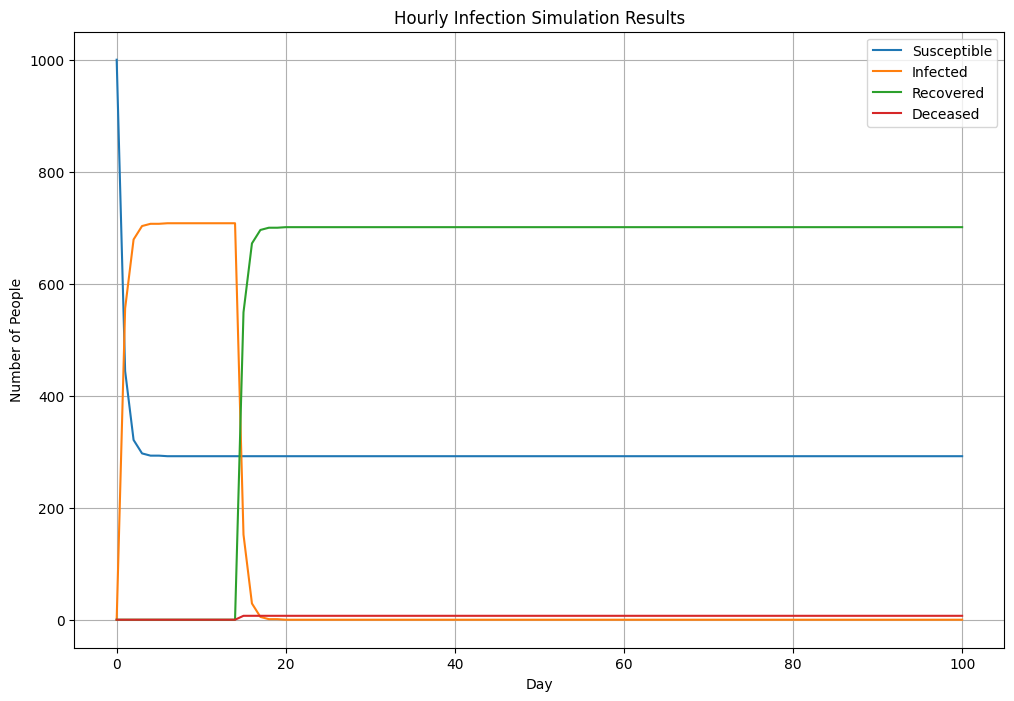

Simulation plot saved to simulation_plot.png


In [7]:
if True:
    SIM_DAYS = 100
    POPULATION_FILE = 'simple_synthetic_population/population-1000.csv'
    INITIAL_INFECTED = 5

    sim_params = {
        'recovery_period_hours': 14 * 24,
        'death_prob': 0.01,
        'isolation_prob': 0.8,
        'hours_to_isolate': 3 * 24,
    }

    print("Loading population...")
    persons, families = load_population(POPULATION_FILE)
    print("Assigning organizations and schedules...")
    assign_organizations(persons)
    assign_schedules(persons)

    print("Starting simulation...")
    simulation = Simulation(persons, families, sim_params)
    simulation.start(initial_infected_count=INITIAL_INFECTED)

    total_hours = SIM_DAYS * 24
    for hour in range(total_hours):
        if (hour % (24 * 10) == 0):
            print(f"Simulating... Hour {hour}/{total_hours} (Day {hour // 24})")
        simulation.run_hourly_step()
    simulation.log_daily_history()

    print("Simulation finished.")
    final_counts = simulation.history[-1]
    print(f"--- Simulation Report (After {SIM_DAYS} days) ---")
    print(f"Susceptible: {final_counts['S']}")
    print(f"Infected:    {final_counts['I']}")
    print(f"Recovered:   {final_counts['R']}")
    print(f"Deceased:    {final_counts['D']}")

    plot_results(simulation.history)


Stan で R0 などを分析してみます。ちょっと時間がかかります。

In [ ]:
fit = analyze_with_stan(simulation.history, len(persons), INITIAL_INFECTED)

Creating Stan trace plot...


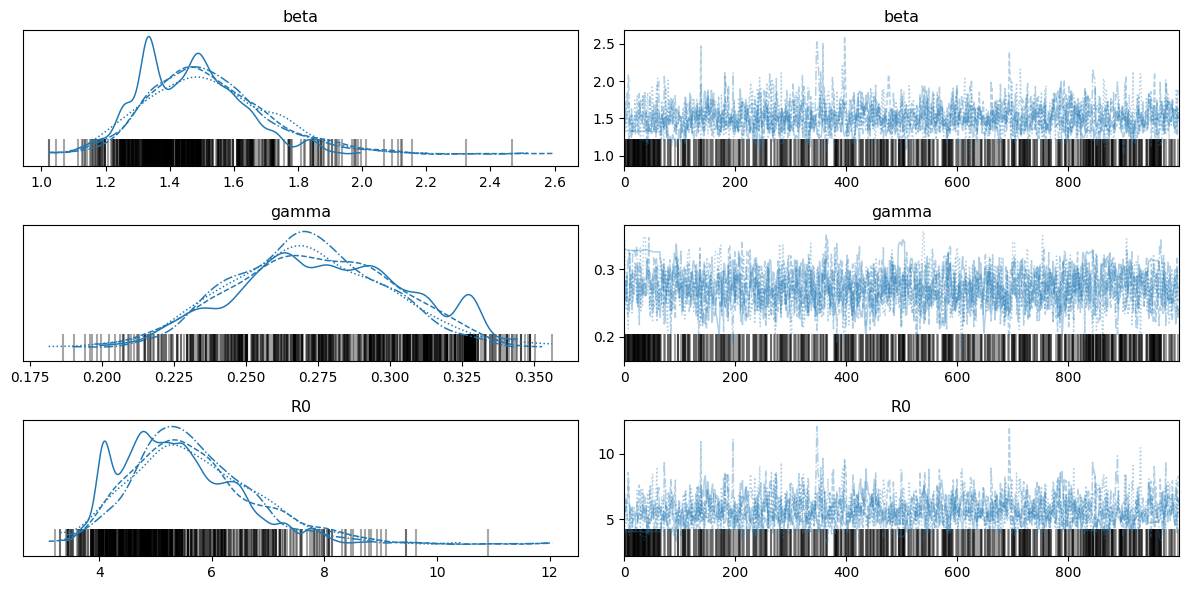

Stan trace plot saved to stan_trace.png
Creating R(t) plot...


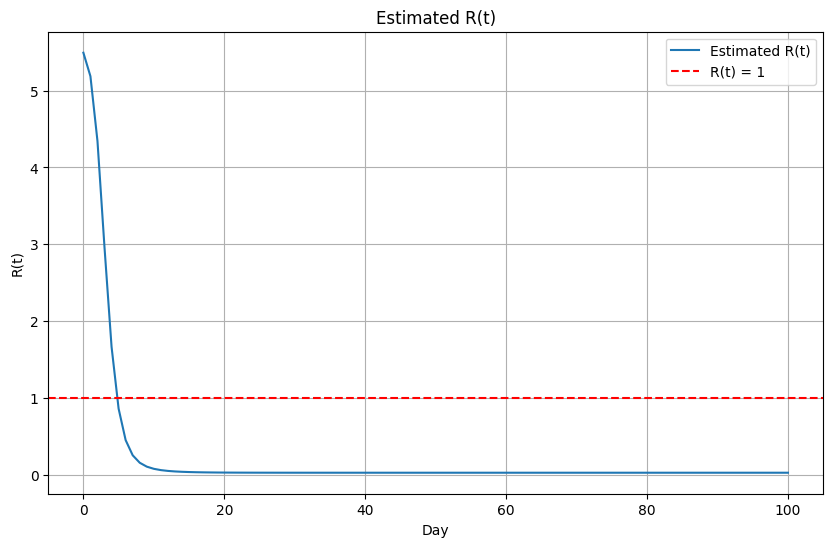

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp786zljm3/stansummary-sir-4dscsre_.csv /tmp/tmp786zljm3/sirqu_y4fsk/sir-20250805065137_1.csv /tmp/tmp786zljm3/sirqu_y4fsk/sir-20250805065137_2.csv /tmp/tmp786zljm3/sirqu_y4fsk/sir-20250805065137_3.csv /tmp/tmp786zljm3/sirqu_y4fsk/sir-20250805065137_4.csv
cwd: None


R(t) plot saved to rt_plot.png

--- Stan Analysis Summary ---
           Mean    StdDev        5%       50%       95%
beta   1.507610  0.184735  1.245990  1.489170  1.840520
gamma  0.273357  0.028460  0.227878  0.272384  0.322488
R0     5.606760  1.094900  4.055740  5.465700  7.637620
---------------------------



In [14]:
plot_stan_result(simulation.history, fit)

いろいろ stan はエラーを出していますが、Gemini さんによるとあまり問題はないそうです。

…ということで、目的としたシミュレーションはできたのでした。

### 今後の課題と判断

*   **パラメータとスケジュールの精緻化**:
    *   各場所の感染確率や、個人のスケジュールパターンは、現在簡易的な設定です。より現実のデータ（例：交通調査、行動ログ）に基づいてこれらのパラメータを調整することで、シミュレーションの精度を高めることができます。
    *   主婦やリタイアした人々の行動モデルは現在実装されていないため、今後の拡張が望まれます。
*   **モデルの拡張**: 全校集会や、異なる会社間の会議など、スケジュールにないランダムな接触イベントを追加することも、より現実的なシミュレーションへの拡張として考えられます。
*   **Stanモデルとの適合性**: 現在のシミュレーションは自己隔離などの複雑な要素を含むため、単純なSIRモデルとは乖離が見られる場合があります。Stanの実行時に発散（divergent transitions）が警告される場合、シミュレーションの動態が単純なSIRモデルの仮定から外れていることを示唆しており、それ自体が分析上の知見となります。

以上が Gemini さん自身による今後の課題になります。私の課題としては次のような感じです。

* これだけ精緻なシミュレーションにしたのだから、もっといろんな適用範囲を見つけたい。大日康史＆菅原民枝『パンデミック・シミュレーション - 感染症数理モデルの応用』(技術評論社 tanQブックス, 2009年8月)によれば、初発者からの広がりにおいて、その初発者がどういう人物かによって広がり方が違い、対策として例えば抗ウィルス薬(タミフルなど)の予防によって封じ込めが行える…等のシミュレーションができ…たりするようなのですが、今後の課題としておきます。